In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from IPython.core.display import clear_output
import random

In [3]:
df20 = pd.read_pickle('raw20.pkl')
df19 = pd.read_pickle('raw19.pkl')

In [4]:
lineup = ['Cole Sager', 'Tim Paulson',
         'Samuel Cournoyer','Tyler Christophel',
         'Patrick Vellner','Jonne Koski',
         'Travis Mayer','Jeffrey Adler',
         'Scott Tetlow','Alexandre Caron',
         'Mathew Fraser','Samuel Kwant',
         'Jacob Heppner','Björgvin Karl Guðmundsson',
         'Bayden Brown','Chandler Smith',
         'Noah Ohlsen','Roman Khrennikov',
         'Brent Fikowski','Khan Porter',
         'Peter Shaw','Luke Schafer',
         'Justin Medeiros','David Shorunke',
         'Griffin Roelle','Saxon Panchik',
         'Jay Crouch','Adam Davidson',
         'Brandon Luckett','Rogelio Gamboa']

points = [100, 96, 92, 88, 84, 80, 76, 72, 68, 64, 60, 56, 52, 49, 46,
         43, 40, 37, 34, 31, 28, 25, 22, 19, 16, 13, 10, 7, 4, 1]

In [5]:
#Data Cleaning/Prep

#drop unnecessary columns
df20_temp = df20[['entrant.competitorName','scores']]
df19_temp = df19[['entrant.competitorName','scores']]

#merge
df_merged = df20_temp.merge(df19_temp, on='entrant.competitorName', how='outer')

#pull only those who are part of Games Lineup, remove NaN values, setup "rank field"
df = df_merged[df_merged['entrant.competitorName'].isin(lineup)].drop_duplicates(subset='entrant.competitorName',keep='first').rename(columns={
    'entrant.competitorName':'Name','scores_x':'scores2020','scores_y':'scores2019'}).reset_index(drop=True)
df = df.fillna(value=0)
df['ranks'] = 0
df['ranks'] = df['ranks'].astype('object')

#pull all scores and create series for each competitor
for i in range(len(df)):
    try:
        ranks20 = [wod['rank'] for wod in df.loc[i,'scores2020']]
    except:
        continue
    
    if df.loc[i,'scores2019'] == 0:
        df.at[i,'ranks'] = ranks20
    else:
        ranks19 = [wod['rank'] for wod in df.loc[i,'scores2019']]
        ranks = ranks20 + ranks19
        df.at[i,'ranks'] = ranks
    
df.head()

,Name,scores2020,scores2019,ranks
0,Patrick Vellner,"[{'ordinal': 1, 'rank': '13', 'score': '118003...","[{'ordinal': 1, 'rank': '193', 'score': '13780...","[13, 19, 12, 18, 2, 193, 2, 263, 9, 20]"
1,Mathew Fraser,"[{'ordinal': 1, 'rank': '8', 'score': '1180039...","[{'ordinal': 1, 'rank': '59', 'score': '138700...","[8, 40, 3, 2, 21, 59, 3, 1, 2, 1]"
2,Björgvin Karl Guðmundsson,"[{'ordinal': 1, 'rank': '2', 'score': '1180040...","[{'ordinal': 1, 'rank': '5', 'score': '1399000...","[2, 12, 18, 62, 3, 5, 21, 32, 21, 14]"
3,Jeffrey Adler,"[{'ordinal': 1, 'rank': '44', 'score': '118003...","[{'ordinal': 1, 'rank': '90', 'score': '138400...","[44, 6, 6, 1, 43, 90, 13, 234, 92, 31]"
4,Noah Ohlsen,"[{'ordinal': 1, 'rank': '22', 'score': '118003...","[{'ordinal': 1, 'rank': '790', 'score': '13580...","[22, 25, 7, 25, 48, 790, 31, 8, 3, 47]"


In [6]:
#Simulation

results_dict = defaultdict(list)
points_dict = defaultdict(list)
avgpoints_dict = defaultdict(list)

sims = 20000

for i in range(sims):
    temp = df.copy()
    
    #confirmed 7 events; otherwise random choice
    num_events = 7 #np.random.choice([7,8,9,10,11],p=[.75,.15,.04,.04,.02])
    
    #allow for different stdevs in the noise variables (conservative to aggressive)
    sigma = np.random.choice([0.3,0.35,0.4])

    for athlete in range(len(temp)):
        rand = random.random()
        
        #1 percent drop out risk
        if rand <= 0.01:
            scores = np.full(num_events,1000000)
        
        #otherwise draw from scores with some variability noise (both overall and event to event)
        else:
            weekend_noise = np.random.normal(1,sigma)
            wod_noise = np.random.normal(1,sigma,num_events)
            scores = np.random.choice(temp.loc[athlete,'ranks'],size=num_events,replace=True).astype(float) * weekend_noise * wod_noise
        
        #assign score to df (scale df by # of events)
        for e in range(num_events):
            col = 'score' + str(e+1)
            temp.at[athlete,col] = scores[e]

    #assign points by rank order of scores for each event
    for event in range(num_events):
        col = 'points' + str(event+1)
        score_col = 'score' + str(event+1)
        temp.sort_values(by=score_col,ascending=True,inplace=True)
        temp[col] = points
    
    #Sum total points
    col_slice = ['points' + str(event+1) for event in range(num_events)]
    
    temp['total'] = temp[col_slice].sum(axis=1)
    temp.sort_values(by='total', ascending=False, inplace=True)
    temp['final_rank'] = list(range(1,31,1))

    #Assign ranks/total points to each athlete's dictionary entry
    for ath in range(len(temp)):
        name = temp.loc[ath,'Name']
        results_dict[name].append(temp.at[ath,'final_rank'])
        points_dict[name].append(temp.at[ath,'total'])
        avgpoints_dict[name].append(temp.at[ath,'total'] / num_events)
    
    #track processing progress
    if i%10 == 0:
        clear_output(wait = True)
        print("Simulation {} of {} complete".format(i,sims))
    if i == (sims-1):
        clear_output(wait = True)
        print("done!")

#Calculate top 5 probabilities
final = df.copy()

for athlete in range(len(final)):
    name = final.loc[athlete,'Name']
    
    temp = np.array(results_dict[name])
    p = np.sum(temp <= 5) / sims
    final.at[athlete,'Top_5_P'] = p

final.sort_values(by='Top_5_P',ascending=False,inplace=True)
final.reset_index(drop=True,inplace=True)

final[['Name','Top_5_P']].head(30)

done!


,Name,Top_5_P
0,Mathew Fraser,0.93510
1,Björgvin Karl Guðmundsson,0.78045
2,Patrick Vellner,0.54865
3,Noah Ohlsen,0.36010
4,Jacob Heppner,0.32835
5,Jeffrey Adler,0.29335
6,Jonne Koski,0.20185
7,Rogelio Gamboa,0.18440
8,Brandon Luckett,0.18050
9,Cole Sager,0.16935


Text(0.5,1,'Stage 1 Crossfit Games: Men Top 5 Probabilities')

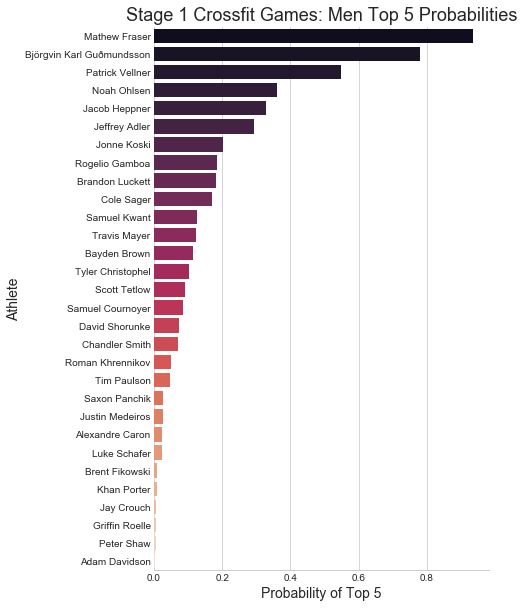

In [7]:
#Plot results
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(6, 10))
ax = sns.set_palette("rocket")
ax = sns.barplot(x = 'Top_5_P', y='Name',data=final,palette="rocket")

sns.despine(left=True)

ax.set_xlabel('Probability of Top 5',size=14)
ax.set_ylabel('Athlete',size=14)
ax.set_title('Stage 1 Crossfit Games: Men Top 5 Probabilities',size=18)

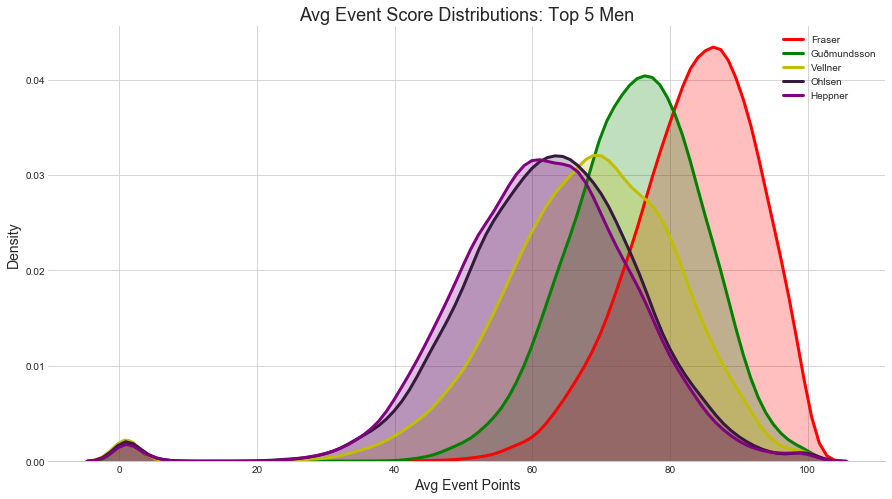

In [11]:
#Plot score distributions for top 5 men

fig, ax = plt.subplots(figsize=(15,8))
ax = sns.distplot(avgpoints_dict['Mathew Fraser'],kde=True,hist=False, color='r', label='Fraser',kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(avgpoints_dict['Björgvin Karl Guðmundsson'],kde=True,hist=False, color='g', label='Guðmundsson',kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(avgpoints_dict['Patrick Vellner'],kde=True,hist=False, color='y', label='Vellner',kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(avgpoints_dict['Noah Ohlsen'],kde=True,hist=False,label='Ohlsen',kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(avgpoints_dict['Jacob Heppner'],kde=True,hist=False, color='purple', label='Heppner',kde_kws = {'shade': True, 'linewidth': 3})

sns.despine(left=True)

ax.set_xlabel('Avg Event Points', size=14)
ax.set_ylabel('Density', size=14)
ax.set_title('Avg Event Score Distributions: Top 5 Men', size=18)
plt.legend()
plt.show()

In [9]:
np.sum(np.array(avgpoints_dict['Noah Ohlsen']) >= np.array(avgpoints_dict['Mathew Fraser'])) / sims

0.10485

In [10]:
np.sum(np.array(results_dict['Jacob Heppner']) == 1) / sims

0.0305